In [20]:
import intake
import xarray as xr

# open ESMCol catalog
cat_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

grid_label = 'gn' # for model native grid
#grid_label = 'gr' # for regridded data

# search and display data
cat = col.search(activity_id='CMIP',
                 experiment_id=['historical','ssp126', 'ssp370','ssp245','ssp585'],
                 table_id='Amon', variable_id='tas', grid_label=grid_label)
len(cat.df)

146

In [16]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [17]:
# these are all of the different models we found
list(dset_dict.keys())

['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.BCC.BCC-ESM1.historical.Amon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn',
 'CMIP.MIROC.MIROC6.historical.Amon.gn',
 'CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn',
 'CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.NCC.NorCPM1.historical.Amon.gn',
 'CMIP.NUIST.NESM3.historical.Amon.gn',
 'CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.UA.MCM-UA-1-0.historical.Amon.gn']

In [18]:
# just operate on one of these
ds = dset_dict['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 320, member_id: 3, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(320, 2), meta=np.ndarray>
    height     float64 ...
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(160, 2), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 160, 320), meta=np.ndarray>
Attributes:
    parent_activity_id:     CMIP
    cmor_version:           3.3.2
    experiment:             all-forcing simulation of the recent past
    license:     

In [30]:
# our cities
# cmip data use 0-360 lons
cities = {'New York': (40.7128, 360-74.0060),
          'Paris': (48.8566, 2.3522),
          'Hong Kong': (22.3193, 114.1694)}

# as xarray dataset
cities_ds = xr.Dataset({'lon': ('city', [v[1] for v in cities.values()]),
                        'lat': ('city', [v[0] for v in cities.values()])},
                       coords={'city': list(cities.keys())})
cities_ds

<xarray.Dataset>
Dimensions:  (city: 3)
Coordinates:
  * city     (city) <U9 'New York' 'Paris' 'Hong Kong'
Data variables:
    lon      (city) float64 286.0 2.352 114.2
    lat      (city) float64 40.71 48.86 22.32

In [31]:
tas_on_cities = ds.tas.interp(lon=cities_ds.lon, lat=cities_ds.lat)
tas_on_cities

<xarray.DataArray 'tas' (member_id: 3, time: 1980, city: 3)>
dask.array<transpose, shape=(3, 1980, 3), dtype=float32, chunksize=(1, 600, 3), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
    lon        (city) float64 286.0 2.352 114.2
    lat        (city) float64 40.71 48.86 22.32
  * city       (city) <U9 'New York' 'Paris' 'Hong Kong'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean (interval: 5 minutes)
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  TREFHT
    standard_name:  air_temperature
    units:          K

In [32]:
# this takes time because the full dataset has to be read
# because the data are chunked contiguously in space
# to speed this up, we could store the "cities" data in its own zarr store on the cloud
%time tas_on_cities.load()

CPU times: user 24.5 s, sys: 9.83 s, total: 34.4 s
Wall time: 18.9 s


<xarray.DataArray 'tas' (member_id: 3, time: 1980, city: 3)>
array([[[268.7901173 , 271.47198186, 290.06014267],
        [271.5389114 , 270.31310707, 291.73601793],
        [277.76855305, 278.57242511, 293.86614268],
        ...,
        [285.66086934, 283.91298199, 299.36247274],
        [281.28334704, 280.94574545, 294.59770758],
        [278.20171602, 280.7895265 , 290.49279853]],

       [[274.66659601, 280.86573067, 289.82251459],
        [271.28412252, 276.89450836, 289.16199039],
        [274.13200943, 282.25432072, 291.47864343],
        ...,
        [285.59722949, 280.21175668, 300.77588501],
        [282.22401386, 281.33257329, 297.74263905],
        [277.26032544, 274.68321263, 291.44880937]],

       [[273.69779607, 279.02057227, 290.88526485],
        [277.43560491, 277.16741134, 291.59994036],
        [279.00291281, 279.56153036, 291.7971482 ],
        ...,
        [286.96187784, 284.93723978, 299.13460079],
        [283.25135925, 280.16244054, 295.52724765],
        [277

In [44]:
tas_pentad_mean = tas_on_cities.resample(time='5AS').mean()

(3, 33, 3)

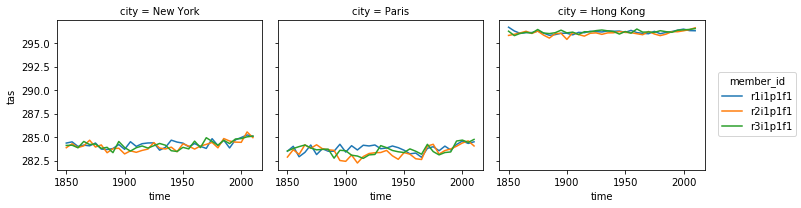

In [42]:
tas_pentad_mean.plot.line(x='time', col='city')

In [58]:
# now do that for a couple of different models

def load_and_resample_timeseries(ds):
    # maybe fix poorly named coordinates
    if 'latitude' in ds.dims:
        ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    tas_on_cities = ds.tas.interp(lon=cities_ds.lon, lat=cities_ds.lat)
    return tas_on_cities.resample(time='5AS').mean()

In [ ]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10)
client = Client(cluster)

In [48]:
cluster

In [66]:
import dask
all_results = [load_and_resample_timeseries(ds) for ds in dset_dict.values()]
all_results_computed = dask.compute(*all_results)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.32.78.12:43034 remote=tcp://10.32.78.12:39879>


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,


<Figure size 432x288 with 0 Axes>

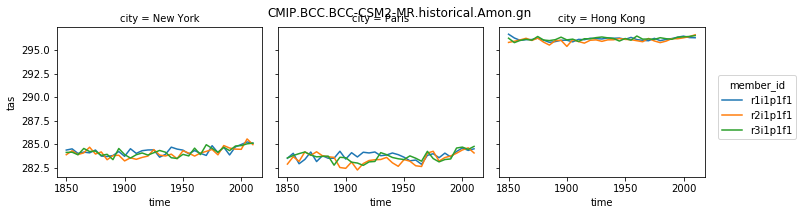

<Figure size 432x288 with 0 Axes>

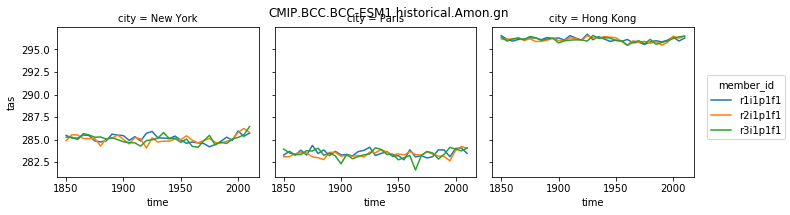

<Figure size 432x288 with 0 Axes>

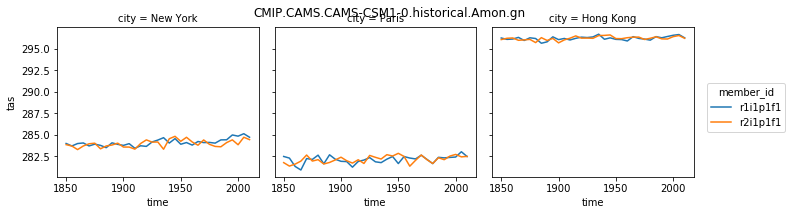

<Figure size 432x288 with 0 Axes>

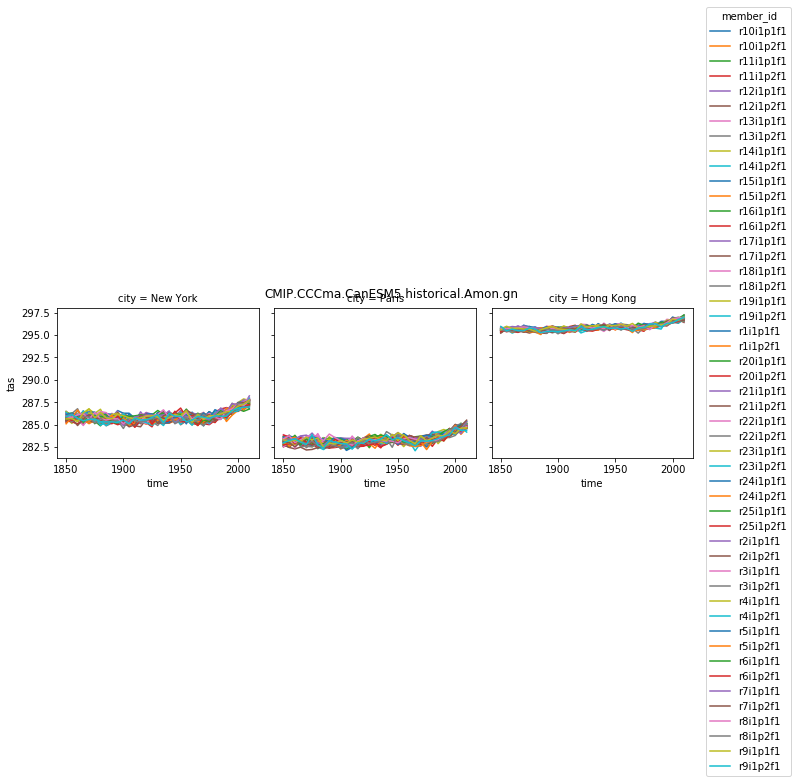

<Figure size 432x288 with 0 Axes>

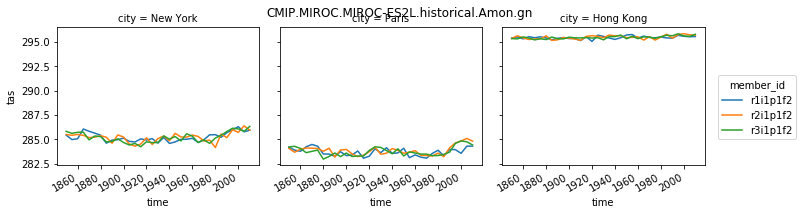

<Figure size 432x288 with 0 Axes>

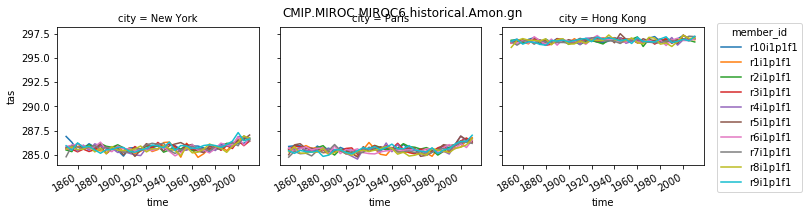

<Figure size 432x288 with 0 Axes>

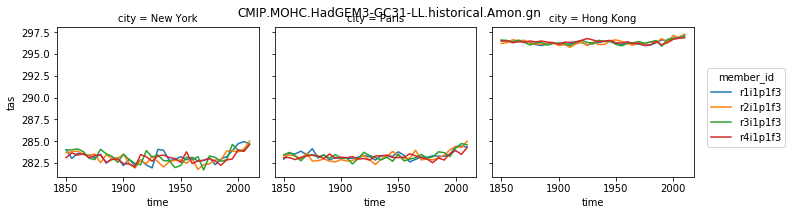

<Figure size 432x288 with 0 Axes>

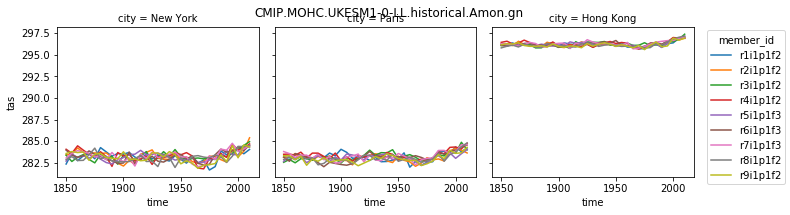

<Figure size 432x288 with 0 Axes>

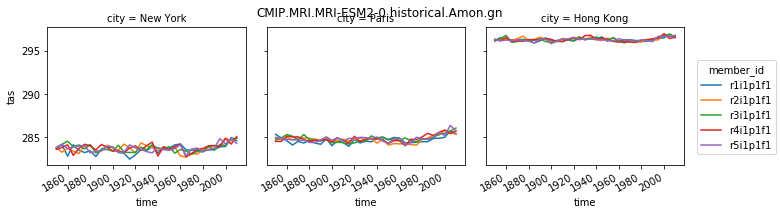

<Figure size 432x288 with 0 Axes>

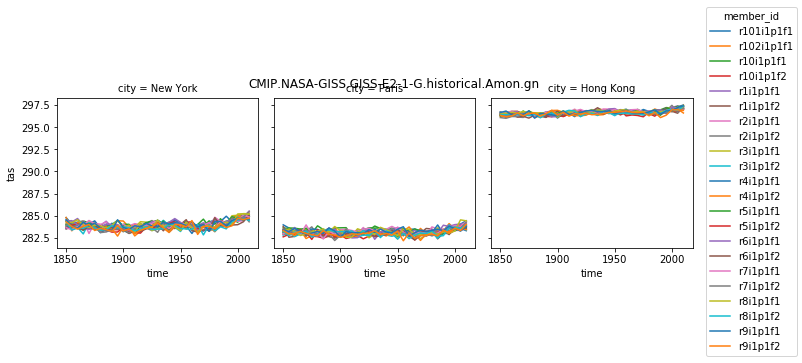

<Figure size 432x288 with 0 Axes>

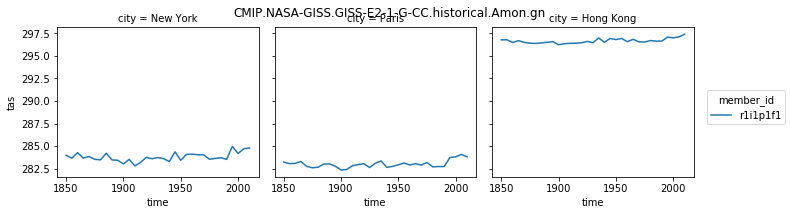

<Figure size 432x288 with 0 Axes>

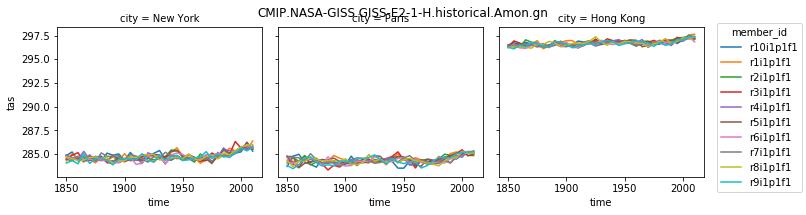

<Figure size 432x288 with 0 Axes>

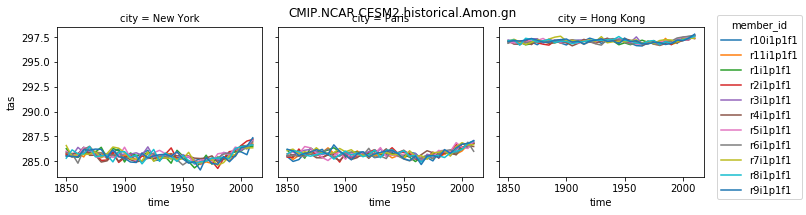

<Figure size 432x288 with 0 Axes>

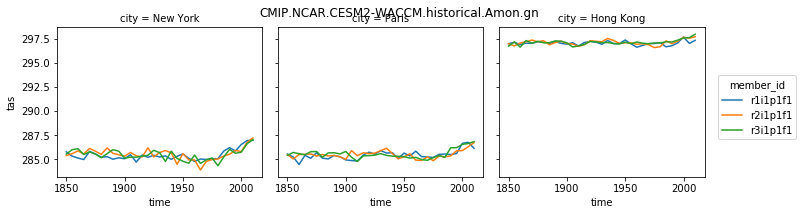

<Figure size 432x288 with 0 Axes>

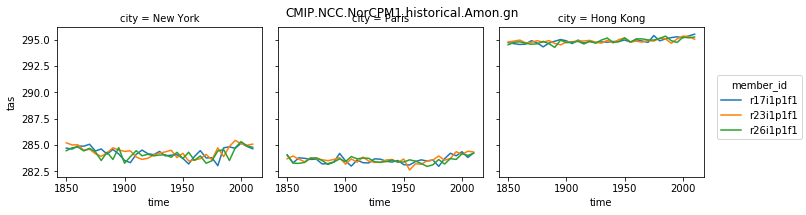

<Figure size 432x288 with 0 Axes>

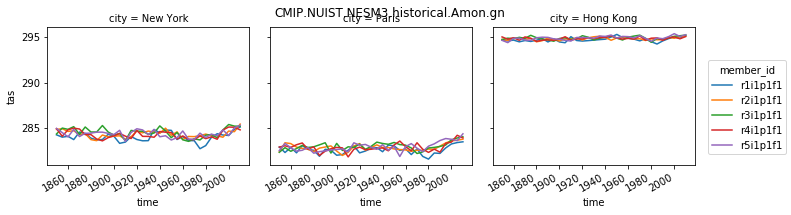

<Figure size 432x288 with 0 Axes>

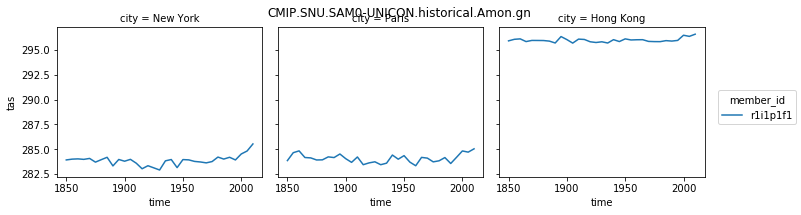

<Figure size 432x288 with 0 Axes>

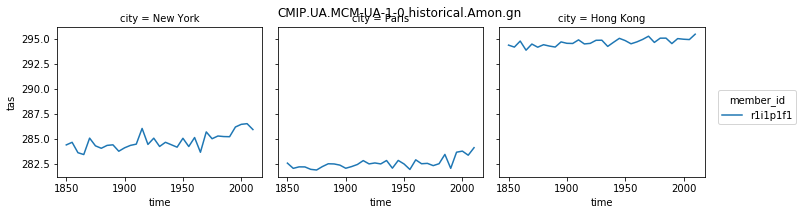

In [68]:
from matplotlib import pyplot as plt

for model, ds_model in zip(dset_dict.keys(), all_results_computed):
    plt.figure()
    ds_model.plot.line(x='time', col='city')
    plt.suptitle(model)

In [69]:
# can we concatenate the datasets across the model dimension - NO!

ds_all = xr.concat(all_results_computed, dim='source_id')
ds_all

TypeError: cannot compare cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, 2, 1) and Timestamp('1850-01-01 00:00:00', freq='5AS-JAN') (different calendars)

The models are on different time calendars. There is no way to merge them without ignoring fundamental differences in the way they represent time. One way to do this would be to just overwrite the time with an integer year.

In [73]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 1980)>
array([1850, 1850, 1850, ..., 2014, 2014, 2014])
Coordinates:
  * time     (time) object 1850-01-17 00:00:00 ... 2014-12-17 00:00:00

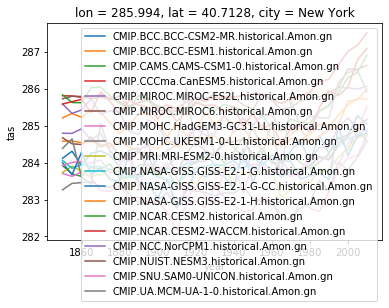

In [77]:
fig, ax = plt.subplots()
for model, ds_model in zip(dset_dict.keys(), all_results_computed):
    ds_model.coords['year'] = ds_model.time.dt.year
    ds_model = ds_model.swap_dims({'time': 'year'})
    ds_model.sel(city='New York').mean(dim='member_id').plot(ax=ax, label=model)
    
plt.legend()